In [1]:
# Math, numpy and torch
import math
import numpy as np
import torch

# SBI
from sbi.inference import prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.utils import RestrictionEstimator

# SciPy
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

In [2]:
# Constants
torch.manual_seed(0)
np.random.seed(0)
tf = 50
dt = 0.01
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]

In [3]:
# Functions
def system(t, z, k1, k2, k3, k4, Ac, xi):
    """
    This function returns the ODE system.

    Args:
        t (paramter): time (optional)
        z (list): state variables
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant
    
    Returns:
        list: ODE system
    """
    x, y = z
    return [- k1*x - k2*y + Ac, k3*x - k4*y + xi*Ac]

def simulate_system(params):
    """Solves the ODE system using the SciPy solver.

    Args:
        params (array): array of parameters. [k1, k2, k3, k4, Ac, Xi] 

    Returns:
        The solution of the ODE system.
    """
    ode = solve_ivp(system, tspan, c0, args = (params[0], params[1], params[2], params[3], params[4], params[5]), t_eval = t) # Paso explicito
    return np.array([ode.y[0], ode.y[1]])

def valid_simulation(x, dt):
    """Returns True or False depending on whether the simulation is valid or not.

    Args:
        x (array): The system state variable.

    Returns:
        A numpy array with the summary statistics (attributes) of the system
    """
    
    if np.any(x < 0): # Not a valid simulation
        return False
    else:
        # Check if the system presents oscillations
        peaks, _ = find_peaks(x, height=0.1, prominence=0.1)
        if len(peaks) > 1:
            # The system has oscillations
            print("Break point peaks")
            return False
        
        # Peak
        # I don't want to use find_peaks for this since I have the min height and min prominence
        Xpeak = np.max(x)
        Tpeak = np.where(x == Xpeak)[0][0] * dt
        
        # Check that if the last value of x is close to the last five second value in the tolerance
        # If it is, then the system has (probably) reached the steady state
        tol = Xpeak * 1e-1
        if math.isclose(x[-1], x[int(-5/dt)], rel_tol=tol): # five second
            x_ss = x[-1]
        else:
            print("Break point SS")
            return False
        
        tau2_index = np.where(np.isclose(x, x_ss + (Xpeak - x_ss)*0.37, atol=tol))
        
        # Grab first index where tau2 * dt is greater than Tpeak
        tol_tau2 = 1e-2;
        try:
            tau2_index = tau2_index[0][tau2_index[0] > Tpeak/dt][0]
            tau2 = tau2_index*dt
            if Xpeak < x_ss+tol_tau2 and Xpeak > x_ss-tol_tau2 or math.isnan(tau2): # This is if there isn't a peak, therefor no tau2
                print("Break point Tau 2 Xpeak")
                return False
        except:
            print("Break point Tau 2 Try")
            return False
        
        # Check that after t peak, there isn't a value of x that is lower to the steady state value - a tolerance
        if np.any(x[int(Tpeak/dt):] < x_ss - 2e-2*Xpeak):
            print("Break point SS after Xpeak")
            return False
        
        return True

In [4]:
prior_min = [0, 0, 0, 0, 0, 0]
prior_max = [2, 2, 0.5, 0.5, 2, 1]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [5]:
simulator, prior = prepare_for_sbi(simulate_system, prior)
restriction_estimator = RestrictionEstimator(prior=prior)

In [6]:
proposals = [prior]
params, x = simulate_for_sbi(simulator, proposals[-1], 1000, num_workers=4, show_progress_bar=False)

for i in range(torch.Tensor.size(x)[0]):
    if not valid_simulation((x[i][0]).numpy(), dt):
        if i == 0:
            invalid_x = x[0].unsqueeze(0)
            invalid_params = params[i].clone().detach().unsqueeze(0)
            #print(invalid_params)
        else:
            #print(params[i].clone().detach())
            invalid_params = torch.cat((invalid_params, params[i].clone().detach().unsqueeze(0)), 0)
            invalid_x = torch.cat((invalid_x, x[i].clone().detach().unsqueeze(0)), 0)
print(f"Invalid simulations: {torch.Tensor.size(invalid_params)[0]}")

Break point Tau 2 Xpeak
Break point SS
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point peaks
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point Tau 2 Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point SS after Xpeak
Break point SS after Xpeak
Break point peaks
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS
Break point Tau 2 Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Try
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point SS after Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS after Xpeak
Break point SS after Xpeak
Break point Tau 2 Xpeak
Break point SS
Bre

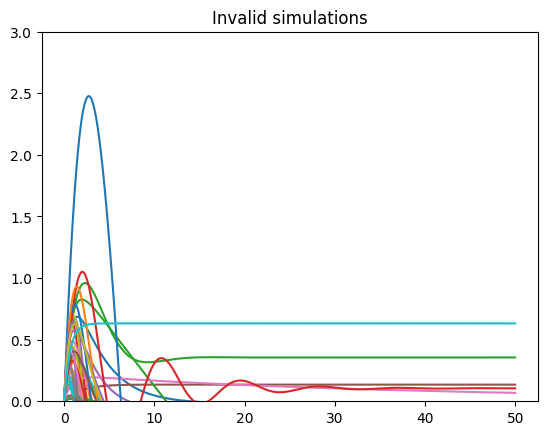

In [7]:
# Plot X invalid simulations
import matplotlib.pyplot as plt
for i in range(120, 160):
    plt.plot(t, invalid_x[i][0])
plt.title("Invalid simulations")
plt.ylim(0, 3)
plt.show()

In [ ]:
# Plot X invalid simulations
idx = 40
plt.plot(t, invalid_x[idx][0])
plt.title("Invalid simulations")
plt.ylim(0, 3)
plt.show()

valid_simulation(invalid_x[idx][0].numpy(), dt)

In [ ]:
restriction_estimator = RestrictionEstimator(prior=prior)
proposals = [prior]

num_rounds = 5
for r in range(num_rounds):
    params, x = simulate_for_sbi(simulator, proposals[-1], 5000, num_workers=4, show_progress_bar=False)
    
    j = 0
    for i in range(torch.Tensor.size(x)[0]):
        if not valid_simulation((x[i][0]).numpy(), dt):
            if j == 0:
                invalid_x = x[i].unsqueeze(0)
                invalid_params = params[i].clone().detach().unsqueeze(0)
                j = 1
            else:
                invalid_params = torch.cat((invalid_params, params[i].clone().detach().unsqueeze(0)), 0)
                invalid_x = torch.cat((invalid_x, x[i].clone().detach().unsqueeze(0)), 0)
    
    print(f"Invalid simulations: {torch.Tensor.size(invalid_params)[0]}")
    restriction_estimator.append_simulations(invalid_params, invalid_x)
    
    if (r < num_rounds - 1):
        classifier = restriction_estimator.train()
    proposals.append(restriction_estimator.restrict_prior())

all_theta, all_x, _ = restriction_estimator.get_simulations()
restricted_prior = restriction_estimator.restrict_prior()

In [ ]:
simulator, prior = prepare_for_sbi(simulate_system, prior)
# inference = SNPE(prior=prior)

In [ ]:
# Maybe another option is to run 2 simulations with 2 different seeds, of 500k each, and combine the results?
params, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=500000, num_workers=6, simulation_batch_size=10000, seed=0)

In [ ]:
torch.save((params, x), 'simulations_1m.pt')

In [ ]:
# np.savetxt("params.csv", params, delimiter=",")
# print("Parameters saved")
# np.savetxt("x.csv", x[:, 0], delimiter=",")
# print("X curve saved")
# np.savetxt("y.csv", x[:, 1], delimiter=",")
# print("Y curve saved")